In [153]:
from langchain.schema import Document
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, END, START
from typing import TypedDict, List, Annotated
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image, display
from uuid import uuid4
from langchain_groq import ChatGroq

In [154]:
load_dotenv()

True

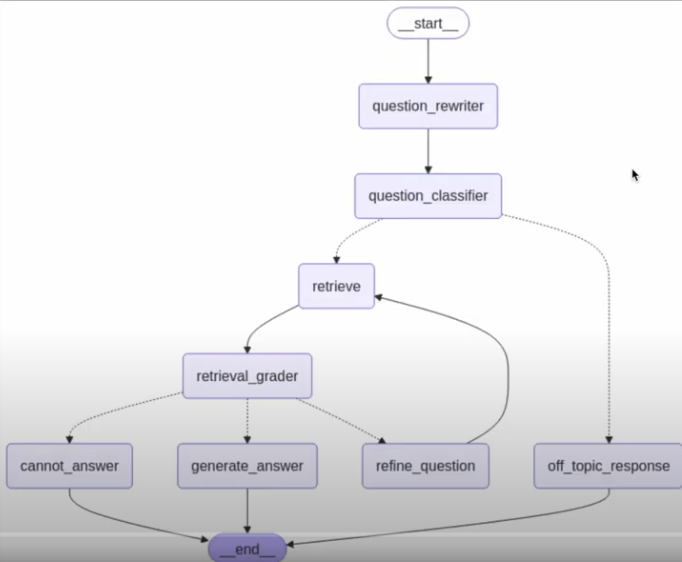

In [155]:
embedding_function=OpenAIEmbeddings()

In [156]:
docs=[
    Document(
        page_content="Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and features state-of-the-art equipment.",
        metadata={"source": "about.txt"}
        ),
    Document(
        page_content="Peak Performance Gym is open Monday through Friday from 5:00 AM to 11:00 PM. On weekends, our hours are 7:00 AM to 9:00 PM. We remain closed on major national holidays. Members with Premium access can enter using their key cards 24/7, including holidays.",
        metadata={"source": "hours.txt"}
        ),
    Document(
        page_content="Our membership plans include: Basic (₹1,500/month) with access to gym floor and basic equipment; Standard (₹2,500/month) adds group classes and locker facilities; Premium (₹4,000/month) includes 24/7 access, personal training sessions, and spa facilities. We offer student and senior citizen discounts of 15% on all plans. Corporate partnerships are available for companies with 10+ employees joining.",
        metadata={"source": "membership.txt"}
        ),
    Document(
        page_content="Group fitness classes at Peak Performance Gym include Yoga (beginner, intermediate, advanced), HIIT, Zumba, Spin Cycling, CrossFit, and Pilates. Beginner classes are held every Monday and Wednesday at 6:00 PM. Intermediate and advanced classes are scheduled throughout the week. The full schedule is available on our mobile app or at the reception desk.",
        metadata={"source": "classes.txt"}
        ),
    Document(
        page_content="Personal trainers at Peak Performance Gym are all certified professionals with minimum 5 years of experience. Each new member receives a complimentary fitness assessment and one free session with a trainer. Our head trainer, Neha Kapoor, specializes in rehabilitation fitness and sports-specific training. Personal training sessions can be booked individually (₹800/session) or in packages of 10 (₹7,000) or 20 (₹13,000).",
        metadata={"source": "trainers.txt"}
        ),
    Document(
        page_content="Peak Performance Gym's facilities include a cardio zone with 30+ machines, strength training area, functional fitness space, dedicated yoga studio, spin class room, swimming pool (25m), sauna and steam rooms, juice bar, and locker rooms with shower facilities. Our equipment is replaced or upgraded every 3 years to ensure members have access to the latest fitness technology.",
        metadata={"source": "facilities.txt"}
        )
    ]

In [157]:
db=Chroma.from_documents(documents=docs,embedding=OpenAIEmbeddings())

In [158]:
retriever=db.as_retriever(search_type="mmr",search_kwargs={"k":3})

In [159]:
llmLlama=ChatGroq(model="llama-3.1-8b-instant")

In [160]:
template="""
Answer the question based only on the following context and the Chathistory. 
Especially take the latest question into consideration:

Chathistory: {history}
Context: {context}
Question: {question}
"""

In [161]:
prompt=ChatPromptTemplate.from_template(template=template)
prompt

ChatPromptTemplate(input_variables=['context', 'history', 'question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'history', 'question'], input_types={}, partial_variables={}, template='\nAnswer the question based only on the following context and the Chathistory. \nEspecially take the latest question into consideration:\n\nChathistory: {history}\nContext: {context}\nQuestion: {question}\n'), additional_kwargs={})])

In [162]:
rag_chain=prompt|llmLlama

In [163]:
class AgentState(TypedDict):
    messages: Annotated[ List[str], add_messages ]
    documents: List[Document]
    on_topic: str
    rephrased_question: str
    proceed_to_generate: bool
    rephrase_count: int
    question: HumanMessage

In [164]:
class GradeQuestion(BaseModel):
    score: str = Field(description="Whether the question is about the specified topics? If yes -> 'Yes' if not -> 'No'")


In [165]:
def question_rewriter(state:AgentState):

    """
    If no messages is present, then initialize the message, then add the question and also assign 
    it to the rephrased question, and finally if there are more than one message, then reframe the last 
    question and assign it to the rephrased question
    """

    print(f"Entering question_rewriter with following state: {state}")
    
    # Reset State Variables except for 'question' and 'messages'
    state['documents']=[]
    state['on_topic']=""
    state['rephrased_question']=""
    state['proceed_to_generate']=False
    state['rephrase_count']=0

    if "messages" not in state or state["messages"] is None:
        state["messages"]=[]
    if state["question"] not in state["messages"]:  # Notice that state["question"] is entering as a Human Message and not raw text
        state['messages']=[state['question']]  # will be appended as per add_message
        # state['messages'].append(state['question'])
        print(f"State Message: {state['messages']}")
    print(f"State Message once question is inserted into the message block: {state['messages']}")
    if len(state['messages'])>1:
        conversations=state["messages"][:-1]
        current_question=state['question'].content
        messages=[
            SystemMessage(content="""
                You are a helpful assistant that rephrases the user's question to be a standalone
                question optimized for retrieval
            """
            )
        ]
        messages+=conversations  # appending the conversations
        messages+=[HumanMessage(content=current_question)]  # appending the question
        print(f"Messages body for rephrasing: {messages}")

        rephrase_prompt=ChatPromptTemplate.from_messages(messages=messages)
        prompt=rephrase_prompt.format()
        
        response=llmLlama.invoke(input=prompt)
        better_question=response.content.strip()
        print(f"Question Rewriter: Rephrased Question: {better_question} ")
        state["rephrased_question"]=better_question
    else:
         state["rephrased_question"]=state['question'].content
    return state

        

In [166]:
def question_classifier(state:AgentState):
    print("Entering Question Classifier")
    system_message=SystemMessage(content="""
    You are a classifier that determines whether a user's question is about one of the following topics

    1. Gym History and Founder
    2. Operating Hours
    3. Membership Plans
    4. Fitness Classes
    5. Personal Trainers
    6. Facilities & Equipments
    7. Anything else about Peak Performance Gym

    If the question IS about any of these topics, respond with 'Yes', otherwise, respond with 'No'
    """
    )
    human_message=HumanMessage(content=state['rephrased_question'])

    grade_prompt=ChatPromptTemplate.from_messages(messages=[system_message,human_message])

    structured_llm=llmLlama.with_structured_output(schema=GradeQuestion)
    grader_chain=grade_prompt|structured_llm

    result=grader_chain.invoke(input={})
    state["on_topic"]=result.score.strip()
    print(f"Question Classifier: on_topic: {state['on_topic']}")
    return state    

In [167]:
def on_topic_router(state:AgentState):
    print("Entering on_topic router")
    on_topic=state.get("on_topic","").lower()
    if on_topic=="yes":
        print("Routing to Retrieve")
        return "retrieve"
    else:
        print("Routing to off_topic_response")
        return "off_topic_response"

In [168]:
def retrieve(state:AgentState):
    print("Entering Retrieve")
    documents=retriever.invoke(state["rephrased_question"])
    print(f"Retriever retrieved: {len(documents)} documents")
    state["documents"]=documents
    return state

In [169]:
class GradeDocument(BaseModel):
    score:str=Field(
        description="Document is relevant to the question? If Yes -> 'Yes' if not-> 'No'"
    )

In [170]:
def retrieval_grader(state:AgentState):
    print("Entering Retrieval Grader")
    system_message=SystemMessage(
        content="""
            You are a grader assessing the relevance of a retrieved document to a user question
            Only answer with 'Yes' or 'No'
        
            If the document contains information relevant to the user's question, respond with 'Yes', otherwise respond with 'No'
        """
    )

    structured_llm=llmLlama.with_structured_output(schema=GradeDocument)

    relevant_docs=[]

    for doc in state["documents"]:
        human_message=HumanMessage(content=f"""
        User Question: {state["rephrased_question"]}
        Retrieved Document: {doc.page_content}
        """
        )
        grade_prompt=ChatPromptTemplate.from_messages(messages=[system_message,human_message])
        grader_chain=grade_prompt|structured_llm
        result=grader_chain.invoke(input={})
        print(f"Grading Document: {doc.page_content[:30]}... Result: {result.score.strip()}")
        if result.score.strip().lower()=="yes":
            relevant_docs.append(doc)

    state["documents"]=relevant_docs
    state["proceed_to_generate"]=len(relevant_docs)>0
    print(f"Retrieval Grader: proceed_to_generate = {state['proceed_to_generate']}")
    return state

In [171]:
def proceed_router(state:AgentState):
    print("Entering proceed router")
    rephrase_count=state.get("rephrase_count",0)
    if state.get("proceed_to_generate",False):
        print("Routing to generate answer")
        return "generate_answer"
    elif rephrase_count>=2:
        print("Maximum rephrase attempts reached. Cannot find relevant documents")
        return "cannot_answer"
    else:
        print("Routing to refine question")
        return "refine_question"

In [172]:
def refine_question(state: AgentState):
    print("Entering refine questions")
    rephrase_count=state.get("rephrase_count",0)
    if rephrase_count>=2:
        print("Maximum rephrase attempts reached")
        return state
    else:
        question_to_refine=state["rephrased_question"]
        system_message=SystemMessage(
            content="""
                You are a helpful assistant that refines the user's question to improve retrieval results.
                Provide a slightly adjusted version of the question
            """
        )
        human_message=HumanMessage(
            content=f"""
            Original Question: {question_to_refine}
            Provide a slightly adjusted version of the question
            """
            )
        refine_prompt=ChatPromptTemplate.from_messages(messages=[system_message,human_message])
        refine_chain=refine_prompt | llmLlama

        response=refine_chain.invoke(input={})
        refined_question=response.content.strip()
        print(f"refine_question: Refined Question: {refined_question}")
        state["rephrased_question"]=refined_question
        state["rephrase_count"]=rephrase_count+1
        return state

In [173]:
def generate_answer(state:AgentState):
    print("Entering generate_answer")
    if "messages" not in state or state["messages"] is None:
        raise ValueError("State must include 'messages' before generating an answer")
    history=state["messages"]
    documents=state["documents"]
    rephrased_question=state["rephrased_question"]

    response=rag_chain.invoke(input={"history":history,"context":documents,"question":rephrased_question})
    generation=response.content.strip()
    state["messages"].append(AIMessage(content=generation))
    print(f"generate_answer: Generated response:{generation}")
    return state

In [174]:
def cannot_answer(state:AgentState):
    print("Entering cannot answer")
    if "messages" not in state or state["messages"] is None:
        state["messages"]=[]
    else:
        state["messages"].append(AIMessage(content="I am sorry, but I cannot find the information you are looking for."))
    return state

In [175]:
def off_topic_response(state:AgentState):
    print("Entering off topic response")
    if "messages" not in state or state["messages"] is None:
        state["messages"]=[]
    else:
        state["messages"].append(AIMessage(content="I am sorry, but I cannot answer this topic since this question is not part of the Gym based context"))

    return state        

In [176]:
checkpointer=MemorySaver()

In [177]:
workflow=StateGraph(state_schema=AgentState)

In [178]:
workflow.add_node(node="question_rewriter",action=question_rewriter)

In [179]:
workflow.add_node(node="question_classifier",action=question_classifier)

In [180]:
workflow.add_node(node="retrieve",action=retrieve)

In [181]:
workflow.add_node(node="retrieval_grader",action=retrieval_grader)

In [182]:
workflow.add_node(node="cannot_answer",action=cannot_answer)

In [183]:
workflow.add_node(node="generate_answer", action=generate_answer)

In [184]:
workflow.add_node(node="refine_question",action=refine_question)

In [185]:
workflow.add_node(node="off_topic_response",action=off_topic_response)

In [186]:
workflow.add_conditional_edges(source="question_classifier",
                               path=on_topic_router,
                               path_map=
                               {
                                        "retrieve": "retrieve",
                                        "off_topic_response": "off_topic_response",
                                        }
                              )

In [187]:
workflow.add_conditional_edges(source="retrieval_grader", 
                               path=proceed_router,
                               path_map={
                                   "generate_answer": "generate_answer",
                                   "refine_question": "refine_question",
                                   "cannot_answer": "cannot_answer"},
                              )

In [188]:
workflow.add_edge(start_key="question_rewriter", end_key="question_classifier")

In [189]:
workflow.add_edge(start_key="retrieve", end_key="retrieval_grader")

In [190]:
workflow.add_edge(start_key="refine_question", end_key="retrieve")

In [191]:
workflow.add_edge(start_key="cannot_answer",end_key=END)

In [192]:
workflow.add_edge(start_key="generate_answer",end_key=END)

In [193]:
workflow.add_edge(start_key="off_topic_response",end_key=END)

In [194]:
workflow.add_edge(start_key=START,end_key="question_rewriter")

In [195]:
workflow.set_entry_point(key="question_rewriter")

In [196]:
graph=workflow.compile(checkpointer=checkpointer)

In [197]:
print(graph.get_graph().draw_ascii())

                                                              +-----------+                                                                   
                                                              | __start__ |                                                                   
                                                              +-----------+                                                                   
                                                                     *                                                                        
                                                                     *                                                                        
                                                                     *                                                                        
                                                          +-------------------+                                                               

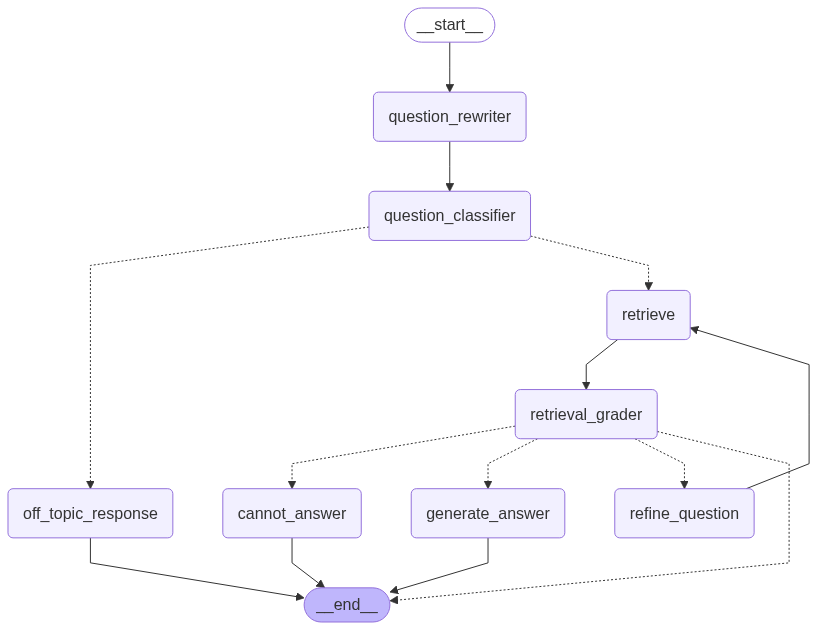

In [198]:
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)
))

In [199]:
config={"configurable":{"thread_id":uuid4()}}

In [200]:
input_data={"question":HumanMessage(content="What does the company Apple do?")}
response=graph.invoke(input=input_data,config=config)

Entering question_rewriter with following state: {'messages': [], 'question': HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={})}
State Message: [HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={})]
State Message once question is inserted into the message block: [HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={})]
Entering Question Classifier
Question Classifier: on_topic: No
Entering on_topic router
Routing to off_topic_response
Entering off topic response


In [201]:
response

{'messages': [HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={}, id='d9b5ebe9-cbc5-444b-9916-72b3655c5b14'),
  AIMessage(content='I am sorry, but I cannot answer this topic since this question is not part of the Gym based context', additional_kwargs={}, response_metadata={}, id='3c643804-ad1a-4924-94b7-cecb63dce38a')],
 'documents': [],
 'on_topic': 'No',
 'rephrased_question': 'What does the company Apple do?',
 'proceed_to_generate': False,
 'rephrase_count': 0,
 'question': HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={}, id='d9b5ebe9-cbc5-444b-9916-72b3655c5b14')}

In [202]:
config={"configurable":{"thread_id":2}}

In [203]:
input_data={"question":HumanMessage(content="What is the cancellation policy for peak performance gym membership?")}
response=graph.invoke(input=input_data,config=config)

Entering question_rewriter with following state: {'messages': [], 'question': HumanMessage(content='What is the cancellation policy for peak performance gym membership?', additional_kwargs={}, response_metadata={})}
State Message: [HumanMessage(content='What is the cancellation policy for peak performance gym membership?', additional_kwargs={}, response_metadata={})]
State Message once question is inserted into the message block: [HumanMessage(content='What is the cancellation policy for peak performance gym membership?', additional_kwargs={}, response_metadata={})]
Entering Question Classifier
Question Classifier: on_topic: Membership Plans
Entering on_topic router
Routing to off_topic_response
Entering off topic response


In [204]:
response

{'messages': [HumanMessage(content='What is the cancellation policy for peak performance gym membership?', additional_kwargs={}, response_metadata={}, id='114d939c-842d-42e9-9e8d-7b73b8bf276a'),
  AIMessage(content='I am sorry, but I cannot answer this topic since this question is not part of the Gym based context', additional_kwargs={}, response_metadata={}, id='bcf1f031-62c1-4364-9e2f-212b79b35569')],
 'documents': [],
 'on_topic': 'Membership Plans',
 'rephrased_question': 'What is the cancellation policy for peak performance gym membership?',
 'proceed_to_generate': False,
 'rephrase_count': 0,
 'question': HumanMessage(content='What is the cancellation policy for peak performance gym membership?', additional_kwargs={}, response_metadata={}, id='114d939c-842d-42e9-9e8d-7b73b8bf276a')}

In [205]:
config={"configurable":{"thread_id":3}}

In [206]:
input_data={"question":HumanMessage(content="Who founded Peak Performance Gym?")}
response=graph.invoke(input=input_data,config=config)

Entering question_rewriter with following state: {'messages': [], 'question': HumanMessage(content='Who founded Peak Performance Gym?', additional_kwargs={}, response_metadata={})}
State Message: [HumanMessage(content='Who founded Peak Performance Gym?', additional_kwargs={}, response_metadata={})]
State Message once question is inserted into the message block: [HumanMessage(content='Who founded Peak Performance Gym?', additional_kwargs={}, response_metadata={})]
Entering Question Classifier
Question Classifier: on_topic: Yes
Entering on_topic router
Routing to Retrieve
Entering Retrieve
Retriever retrieved: 3 documents
Entering Retrieval Grader
Grading Document: Peak Performance Gym was found... Result: Yes
Grading Document: Group fitness classes at Peak ... Result: No
Grading Document: Personal trainers at Peak Perf... Result: No
Retrieval Grader: proceed_to_generate = True
Entering proceed router
Routing to generate answer
Entering generate_answer
generate_answer: Generated response

In [207]:
response

{'messages': [HumanMessage(content='Who founded Peak Performance Gym?', additional_kwargs={}, response_metadata={}, id='7afe8e82-5847-42ff-a811-fd8fc4437f0f'),
  AIMessage(content='Marcus Chen founded Peak Performance Gym.', additional_kwargs={}, response_metadata={}, id='f818f59c-a34c-42c6-a19b-387d5957add9')],
 'documents': [Document(metadata={'source': 'about.txt'}, page_content='Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and features state-of-the-art equipment.')],
 'on_topic': 'Yes',
 'rephrased_question': 'Who founded Peak Performance Gym?',
 'proceed_to_generate': True,
 'rephrase_count': 0,
 'question': HumanMessage(content='Who founded Peak Performance Gym?', additional_kwargs={}, response_metadata={}, id='7afe8e82-5847-42ff-a811-fd8fc4437f0f')}

In [209]:
input_data={"question":HumanMessage(content="When did he start it?")}
response=graph.invoke(input=input_data,config=config)

Entering question_rewriter with following state: {'messages': [HumanMessage(content='Who founded Peak Performance Gym?', additional_kwargs={}, response_metadata={}, id='7afe8e82-5847-42ff-a811-fd8fc4437f0f'), AIMessage(content='Marcus Chen founded Peak Performance Gym.', additional_kwargs={}, response_metadata={}, id='f818f59c-a34c-42c6-a19b-387d5957add9'), HumanMessage(content='When did he start it?', additional_kwargs={}, response_metadata={}, id='3f3e8d8f-8f79-4499-96fe-4252c4620404')], 'documents': [], 'on_topic': '', 'rephrased_question': 'When did he start it?', 'proceed_to_generate': False, 'rephrase_count': 0, 'question': HumanMessage(content='When did he start it?', additional_kwargs={}, response_metadata={})}
State Message: [HumanMessage(content='When did he start it?', additional_kwargs={}, response_metadata={})]
State Message once question is inserted into the message block: [HumanMessage(content='When did he start it?', additional_kwargs={}, response_metadata={})]
Entering

In [210]:
response

{'messages': [HumanMessage(content='Who founded Peak Performance Gym?', additional_kwargs={}, response_metadata={}, id='7afe8e82-5847-42ff-a811-fd8fc4437f0f'),
  AIMessage(content='Marcus Chen founded Peak Performance Gym.', additional_kwargs={}, response_metadata={}, id='f818f59c-a34c-42c6-a19b-387d5957add9'),
  HumanMessage(content='When did he start it?', additional_kwargs={}, response_metadata={}, id='3f3e8d8f-8f79-4499-96fe-4252c4620404'),
  HumanMessage(content='When did he start it?', additional_kwargs={}, response_metadata={}, id='47c1c415-25be-4e88-97af-b67117213a89'),
  AIMessage(content='According to the previous conversation and the context, Marcus Chen founded Peak Performance Gym in 2015.', additional_kwargs={}, response_metadata={}, id='34713fb1-cb2c-4b71-977b-e6f2925e1916')],
 'documents': [Document(metadata={'source': 'about.txt'}, page_content='Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professio

In [211]:
response.keys()

dict_keys(['messages', 'documents', 'on_topic', 'rephrased_question', 'proceed_to_generate', 'rephrase_count', 'question'])

In [212]:
response['messages'][-1]

AIMessage(content='According to the previous conversation and the context, Marcus Chen founded Peak Performance Gym in 2015.', additional_kwargs={}, response_metadata={}, id='34713fb1-cb2c-4b71-977b-e6f2925e1916')